## Image classification with VGG convolutional neural network using Keras

This code is based on a tutorial on medium: https://medium.com/analytics-vidhya/image-classification-with-vgg-convolutional-neural-network-using-keras-for-beginners-61767950c5dd 

### Import all necessary packages 

In [1]:
# import the VGG model from the module vgg.py
from vgg import *

# import the necessary packages
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from keras.callbacks import ModelCheckpoint, TerminateOnNaN, TensorBoard,ReduceLROnPlateau
from imutils import paths
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import argparse
import random
import pickle
import cv2
import os, sys
import copy

from loguru import logger
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

logger.debug('All modules imported')

2022-02-01 15:14:43.932 | DEBUG    | __main__:<module>:27 - All modules imported


### Prepare and load the dataset.

In [2]:
# current working directory from which main.py is located
cur_dir = os.getcwd()

# the data is located in this data_dir
data_dir = os.path.join(cur_dir, 'Dataset')

# the output model and the graph is saved in this 'output_dir'
output_dir = os.path.join(cur_dir, 'Output')

logger.debug("[INFO] loading images...")
data = []
labels = []

# grab the image paths and shuffle them
imagePaths = sorted(list(paths.list_images(data_dir) ))
random.seed(2)
random.shuffle(imagePaths)

IMAGE_WIDTH, IMAGE_HEIGHT = 64, 64

# loop over the input image paths
for imagePath in imagePaths:

    # load the image
    image = cv2.imread(imagePath)

    # resize it
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
    
    # append to the data list
    data.append(image)

    # extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

logger.debug('[INFO] data loaded complete...')

2022-02-01 15:14:44.007 | DEBUG    | __main__:<module>:10 - [INFO] loading images...
2022-02-01 15:14:55.165 | DEBUG    | __main__:<module>:37 - [INFO] data loaded complete...


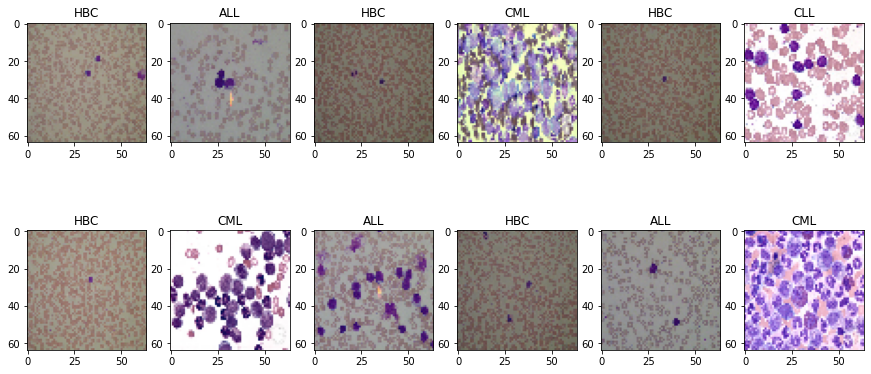

In [3]:
row,col = 2,6
fig, axs = plt.subplots(row, col, figsize=(15, 7))
    
count = 0
for r in range(row):
    for ax in axs[r] :
        ax.imshow(cv2.cvtColor(data[count], cv2.COLOR_BGR2RGB))
        ax.set_title(labels[count])
        ax.grid(False)
        count = count + 1        
plt.show()

In [4]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Binarize labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# save the encoder to output directory
with open(os.path.join(output_dir,'labels'), 'wb') as f:
    pickle.dump(lb, f)

# Randomly split the data into test and train sets (15% test and 85% train)
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.15, random_state=42)

In [5]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=45, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

# initialize our VGG-like Convolutional Neural Network
model = VGGNet.build(width=IMAGE_WIDTH, height=IMAGE_HEIGHT, depth=3, classes=len(lb.classes_))

In [6]:
# initialize our initial learning rate, # of epochs to train for,and batch size
INIT_LR = 0.0007
EPOCHS = 40
BS = 64

# Checkpoints between the training steps
model_checkpoint = ModelCheckpoint(filepath='VGG_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=20)
# Termination of training if the loss become Nan
terminate_on_nan = TerminateOnNaN()

# For watching the live loss, accuracy and graphs using tensorboard
t_board = TensorBoard(log_dir='./logs', 
                      histogram_freq=0,
                      batch_size=32, 
                      write_graph=True, 
                      write_grads=False,
                      write_images=False, 
                      embeddings_freq=0, 
                      update_freq='epoch')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.00001)

callbacks = [model_checkpoint, t_board, terminate_on_nan, reduce_lr]

# initialize the model and optimizers
opt = Adam(lr=INIT_LR, beta_1=0.9, beta_2=0.999, amsgrad=False)


model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the network
logger.debug('Training the network...')
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS,callbacks=callbacks)


# Save the model locally for use later
model_path = os.path.join(output_dir,  'trained_VGG_model.h5')
model.save(model_path)



C:\Users\Hugo-Tech-606\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-02-01 15:14:56.880 | DEBUG    | __main__:<module>:40 - Training the network...
C:\Users\Hugo-Tech-606\AppData\Local\Temp\ipykernel_20704\2152253663.py:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),


Epoch 1/40
2/2 [==============================] - 3s 574ms/step - loss: 2.4429 - accuracy: 0.2154 - val_loss: 1.5869 - val_accuracy: 0.1739 - lr: 7.0000e-04
Epoch 2/40
2/2 [==============================] - 1s 917ms/step - loss: 1.5094 - accuracy: 0.5077 - val_loss: 1.5957 - val_accuracy: 0.1739 - lr: 7.0000e-04
Epoch 3/40
2/2 [==============================] - 1s 159ms/step - loss: 1.2946 - accuracy: 0.5538 - val_loss: 1.6138 - val_accuracy: 0.1739 - lr: 7.0000e-04
Epoch 4/40
2/2 [==============================] - 2s 780ms/step - loss: 0.9758 - accuracy: 0.6562 - val_loss: 1.6334 - val_accuracy: 0.1739 - lr: 7.0000e-04
Epoch 5/40
2/2 [==============================] - 1s 172ms/step - loss: 0.7863 - accuracy: 0.7692 - val_loss: 1.6606 - val_accuracy: 0.1739 - lr: 7.0000e-04
Epoch 6/40
2/2 [==============================] - 2s 767ms/step - loss: 0.7547 - accuracy: 0.7500 - val_loss: 1.6957 - val_accuracy: 0.1739 - lr: 7.0000e-04
Epoch 7/40
2/2 [==============================] - 1s 834ms

In [7]:
testX.shape
predictions = model.predict(testX)
predictions[2]

array([1.3580769e-02, 1.8936771e-04, 2.5383628e-05, 9.6704762e-06,
       9.8619485e-01], dtype=float32)

In [11]:
# evaluate the network
logger.debug('Making predictions and evaluating the trained model.')
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=lb.classes_))


# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training/Validation Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig(os.path.join(output_dir ,'vggnet_plot.png'))

2022-02-01 15:17:18.087 | DEBUG    | __main__:<module>:2 - Making predictions and evaluating the trained model.


ValueError: Number of classes, 4, does not match size of target_names, 5. Try specifying the labels parameter

## Checking Accuracy Using the Confusion Matrix 

In [ ]:
from sklearn.metrics import confusion_matrix